In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
from scipy.stats import norm
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import vega

# Question 1

## Calculate time to maturity

In [2]:
# Calculate time to maturity using calendar days
# current date 02/25/2022
# expiration date 03/18/2022

startDate = date(2022, 2, 25)
endDate = date(2022, 3, 18)

days = (endDate - startDate).days
daysYear = 365
ttm = days / daysYear #using calendar days 
print("The time to maturity is %f" % ttm)

The time to maturity is 0.057534


## Plot the value of call and put for implied volatities in range 10% to 80%

### Black-Scholes Method

In [3]:
def BlackScholes (optionType, S, X, T, sigma, r, b):
    '''
    S: Underlying Price
    X: Strike Price
    T: Time to Maturity
    sigma: Implied Volatility
    r: Risk free rate
    b: cost of carry
    '''
    d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if optionType == "Call":
        price = S * np.exp((b-r)*T) * norm.cdf(d1,0,1) - X * np.exp(-r*T) * norm.cdf(d2,0,1)
    else:
        price = X * np.exp(-r*T) * norm.cdf(-d2,0,1) - S * np.exp((b-r)*T) * norm.cdf(-d1,0,1)
        
    return price

In [4]:
#calculate call option price
optionType = "Call"
S = 165
X = S
T = ttm
r = 0.0025
couponRate = 0.0053
b = r - couponRate
sigma = np.linspace(0.1, 0.8, 100)

callPrice = np.empty(len(sigma))
for i in range(len(sigma)):
    callPrice[i] = BlackScholes(optionType, S, X, T, sigma[i], r, b)

In [5]:
#calculate put option price
optionType = "Put"
S = 165
X = S
T = ttm
r = 0.0025
couponRate = 0.0053
b = r - couponRate
sigma = np.linspace(0.1, 0.8, 100)

putPrice = np.empty(len(sigma))
for i in range(len(sigma)):
    putPrice[i] = BlackScholes(optionType, S, X, T, sigma[i], r, b)

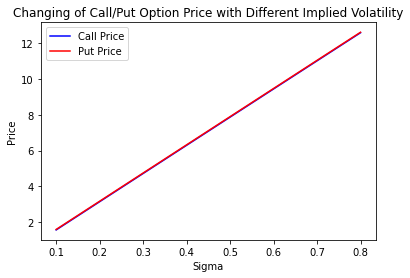

In [6]:
#draw plot
plt.title("Changing of Call/Put Option Price with Different Implied Volatility")
plt.plot(sigma, callPrice, color = 'b', label = "Call Price")
plt.plot(sigma, putPrice, color = 'r', label = "Put Price")
plt.legend()
plt.xlabel("Sigma")
plt.ylabel("Price")
plt.show()

# Question 2

In [7]:
#read data
appl = pd.read_csv("AAPL_Options.csv")

## Newton's method to calculate implied volatility

In [8]:
def impliedVolatility (S, X, T, r, market_price, tol, optionType):
    '''
    S: Underlying Price
    X: Strike Price
    T: Time to Maturity
    r: Risk free rate
    tol: tolerance
    '''
    
    max_iter = 9999
    iv_old = 0.5
    
    for i in range(max_iter):
        bs_price = bs(optionType, S, X, T, r, iv_old)
        vega_price = vega(optionType, S, X, T, r, iv_old) * 100
        gap = bs_price - market_price
        
        iv_new = iv_old - gap/vega_price
        new_bs_price = bs(optionType, S, X, T, r, iv_new)
        
        if (abs(iv_old - iv_new) < tol or abs(new_bs_price - bs_price) < tol):
            break
        
        iv_old = iv_new
        
    impliedVolatility = iv_new
    return impliedVolatility

In [9]:
call_num = appl['Type'].value_counts()['Call']
put_num = appl['Type'].value_counts()['Put']

call_strike = []
put_strike = []
call_iv = []
put_iv = []

S = 164.85
T = ttm
r = 0.0025
tol = 0.00001

for i in range(len(appl)):
    if appl['Type'][i] == "Call":
        call_strike.append(appl["Strike"][i]) #add strike price
        X = appl["Strike"][i]
        market_price = appl["Last Price"][i]
        optionType = "c"
        Civ = impliedVolatility (S, X, T, r, market_price, tol, optionType)
        call_iv.append(Civ) #add implied volatility
    elif appl['Type'][i] == "Put":
        put_strike.append(appl["Strike"][i]) #add strike price
        X = appl["Strike"][i]
        market_price = appl["Last Price"][i]
        optionType = "p"
        Piv = impliedVolatility (S, X, T, r, market_price, tol, optionType)
        put_iv.append(Piv) #add implied volatility
    else:
        raise TypeError("Please check the dataframe")
        
call_strike = np.array(call_strike)
call_iv = np.array(call_iv)
put_strike = np.array(put_strike)
put_iv = np.array(put_iv)

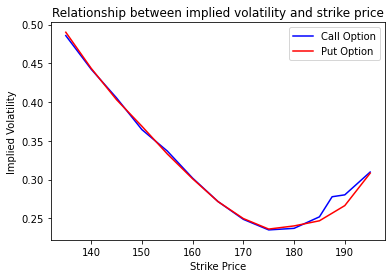

In [10]:
#draw plot
plt.title("Relationship between implied volatility and strike price")
plt.plot(call_strike, call_iv, color = 'b', label = "Call Option")
plt.plot(put_strike, put_iv, color = 'r', label = "Put Option")
plt.legend()
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.show()

# Question 3

In [11]:
# load data
dailyReturn = pd.read_csv("DailyReturn.csv")
p3 = pd.read_csv("problem3.csv")

## Each Portfolio Value over a Range of Underlying Values

In [12]:
# reset some value for impliedVolatility function

S = 164.85
T = ttm
r = 0.0025
couponRate = 0.0053
b = r - couponRate
tol = 0.00001

In [13]:
# using the implied volatility function to calculate the IV
IV = []

for i in range(len(p3.index)):
    if p3.Type[i] == "Stock":
        IV.append(None)
    else:
        if p3.OptionType[i] == "Call":
            iv = impliedVolatility(S, p3.Strike[i], T, r, p3.CurrentPrice[i], tol, "c")
            IV.append(iv)
        else:
            iv = impliedVolatility(S, p3.Strike[i], T, r, p3.CurrentPrice[i], tol, "p")
            IV.append(iv)
    
p3["ImpliedVolatility"] = IV
p3

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice,ImpliedVolatility
0,Straddle,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.289198
1,Straddle,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.274851
2,SynLong,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.289198
3,SynLong,Option,AAPL,-1,Put,3/18/2022,165.0,4.40,0.274851
4,CallSpread,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.289198
5,CallSpread,Option,AAPL,-1,Call,3/18/2022,175.0,0.72,0.235654
6,PutSpread,Option,AAPL,1,Put,3/18/2022,165.0,4.40,0.274851
7,PutSpread,Option,AAPL,-1,Put,3/18/2022,155.0,1.60,0.332303
8,Stock,Stock,AAPL,1,NaN,NaN,NaN,164.85,NaN
9,Call,Option,AAPL,1,Call,3/18/2022,165.0,4.50,0.289198


In [14]:
# calculate the option price for a range of underlying asset
Range = np.arange(S-10, S+10, 1)
val = []
for x in np.nditer(Range):
    for i in range(len(p3.index)):
        if p3.Type[i] == "Stock":
            val.append(x)
        else:
            if p3.OptionType[i] == "Call":
                value = BlackScholes("Call", x, p3.Strike[i], T, p3.ImpliedVolatility[i], r, b)
                val.append(value)
            else:
                value = BlackScholes("Put", x, p3.Strike[i], T, p3.ImpliedVolatility[i], r, b)
                val.append(value)
                
# add the value and underlying information to the database
df_val = pd.DataFrame(val, columns = ['Value'])    
p = pd.concat([p3]*20).reset_index()
p3 = p.join(df_val, how='outer')
p3['UnderlyingPrice'] = np.repeat(Range, 15)

In [15]:
# see the value for each portfolio for different underlying value
comb = p3.groupby(['Portfolio','UnderlyingPrice'])['Value'].sum()
comb = pd.DataFrame(comb).reset_index()

p3 = pd.pivot_table(comb, index='UnderlyingPrice',columns = 'Portfolio', values='Value')

Text(0, 0.5, 'Market Price')

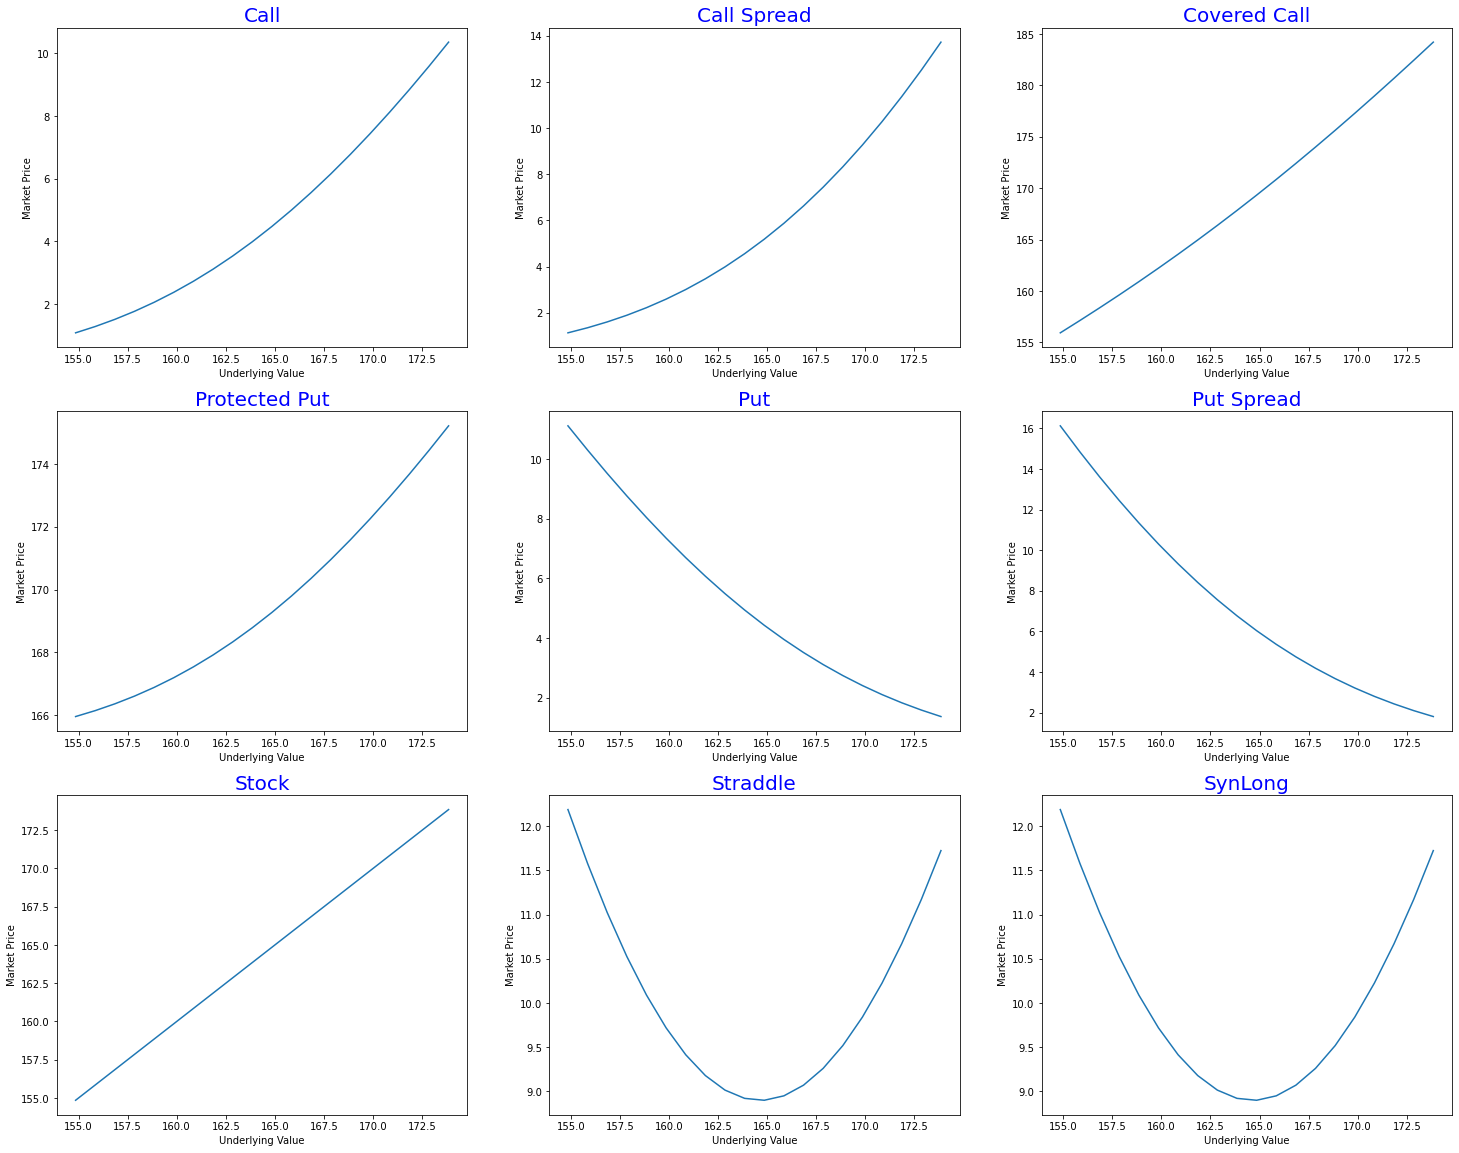

In [16]:
# plot the portfolio values
fig, axes = plt.subplots(3, 3, figsize=(25, 20))

# Call
ax1 = plt.subplot(331)
ax1.plot(p3.iloc[:,0]) 
plt.title('Call',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# CallSpread
ax2 = plt.subplot(332)
ax2.plot(p3.iloc[:,1]) 
plt.title('Call Spread',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Covered Call
ax3 = plt.subplot(333)
ax3.plot(p3.iloc[:,2]) 
plt.title('Covered Call',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Protected Put
ax4 = plt.subplot(334)
ax4.plot(p3.iloc[:,3]) 
plt.title('Protected Put',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Put
ax5 = plt.subplot(335)
ax5.plot(p3.iloc[:,4]) 
plt.title('Put',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Put Spread
ax6 = plt.subplot(336)
ax6.plot(p3.iloc[:,5]) 
plt.title('Put Spread',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Stock
ax7 = plt.subplot(337)
ax7.plot(p3.iloc[:,6]) 
plt.title('Stock',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# Straddle
ax8 = plt.subplot(338)
ax8.plot(p3.iloc[:,7]) 
plt.title('Straddle',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

# SynLong
ax9 = plt.subplot(339)
ax9.plot(p3.iloc[:,8]) 
plt.title('SynLong',fontsize=20, color = 'b')
plt.xlabel("Underlying Value")
plt.ylabel("Market Price")

## Calculate Mean, VaR, and ES

In [17]:
p3 = pd.read_csv("problem3.csv")

# reset some value for impliedVolatility function

S = 164.85
T = ttm
r = 0.0025
couponRate = 0.0053
b = r - couponRate
tol = 0.00001

# using the implied volatility function to calculate the IV
IV = []

for i in range(len(p3.index)):
    if p3.Type[i] == "Stock":
        IV.append(None)
    else:
        if p3.OptionType[i] == "Call":
            iv = impliedVolatility(S, p3.Strike[i], T, r, p3.CurrentPrice[i], tol, "c")
            IV.append(iv)
        else:
            iv = impliedVolatility(S, p3.Strike[i], T, r, p3.CurrentPrice[i], tol, "p")
            IV.append(iv)
    
p3["ImpliedVolatility"] = IV

In [21]:
# remove the mean
aapl = pd.DataFrame(dailyReturn.loc[:, 'AAPL'])
aapl = aapl - aapl.mean()

# fit normal distribution
mean = aapl.mean()
std = aapl.std()

np.random.seed(1998)
sim = 10
norm = np.random.normal(mean, std, sim)

In [25]:
p = 164.85
price = []
for i in np.nditer(norm): 
    p = (1+i)*p
    price.append(p)
    
price = np.array(price)
    
current=[]
n = list(range(1,11))
days = np.repeat(n,15)
for i in days:
    dateNow = pd.Timestamp('2022-2-25') + pd.DateOffset(i)
    current.append(dateNow)
    
p3['ExpirationDate'] = pd.to_datetime(p3['ExpirationDate'])

val=[]
i = 0
for S in price:
    for i in range(len(p3.index)):
        if p3.Type[i] == "Stock":
            val.append(x)
        else:
            T = (p3['ExpirationDate'][i]-current[i]).days/365
            if p3.OptionType[i] == "Call":
                value = BlackScholes("Call", S, p3.Strike[i], T, p3.ImpliedVolatility[i], r, b)
                val.append(value)
            else:
                value = BlackScholes("Put", S, p3.Strike[i], T, p3.ImpliedVolatility[i], r, b)
                val.append(value)

AttributeError: 'numpy.ndarray' object has no attribute 'cdf'